In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
import utils as data_utils

###------------------------------------
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import copy


In [70]:
Freq=np.arange(0.06,0.36,0.01)*1e3
Brust=5/(Freq*1e-3)
Fss=2
#------------------# velocity calculated
Velocity=pd.read_csv('EnergyVelocity.txt', skiprows=4, delimiter=';')
Freq_velocity=np.linspace(0.05,0.4,500)*1e3
print(Velocity.shape)
Velo_A0=Velocity[Velocity.keys()[1]]
fA0 = interpolate.interp1d(Freq_velocity, Velo_A0)(Freq)

(500, 3)


In [71]:
def norm(x):
    return x/np.amax(abs(x), axis=-1, keepdims=True)

In [72]:
Exp_P=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Experiment\Exp_Hole_DATA.npy')
Exp_D=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Experiment\Exp_CRACKLENGTH_DATA.npy')
Exp_T=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Experiment\Exp_TimeVector.npy')
Exp_CL=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Experiment\Exp_CrackLengthInput.npy')
Nend=327
Exp_T_w_row=Exp_T[:Nend]
Exp_P_w_row_t=norm(data_utils.window_Matrix_function(Exp_P[...,:Nend],Brust,fA0,Fss)) # Number of Time domain
Exp_D_w_row_t=norm(data_utils.window_Matrix_function(Exp_D[...,:Nend],Brust,fA0,Fss))

6
6


In [73]:
Exp_P_w_row=Exp_P_w_row_t[4,:,:,0,1,:299]
Exp_D_w_row=Exp_D_w_row_t[4,20,:,0,1,:299]

In [74]:
simFrequency=100
index=np.argmin(abs(Freq-simFrequency))
print("Simulation Excitation frequency is =",Freq[index])
Sim_P=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Simulation\Sim_Hole_DATA.npy')
Sim_D=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Simulation\Sim_CRACKLENGTH_DATA.npy')
Sim_T=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Simulation\Sim_TimeVector.npy').T
Sim_CL=np.load('E:\Work\Work\POD_Analysis\POD_DATA\Simulation\Sim_CrackLengthInput.npy')
Sim_P_w_row=norm(data_utils.window_Matrix_function(Sim_P,[Brust[index]],[fA0[index]],Fss)) # Number of Time domain
Sim_D_w_row=norm(data_utils.window_Matrix_function(Sim_D,[Brust[index]],[fA0[index]],Fss))
Sim_D_w_row=Sim_D_w_row[:,19:20,:,0,1,:]
Sim_P_w_row=Sim_P_w_row[:,:,:,0,1,:]

Simulation Excitation frequency is = 99.99999999999997
6
6


In [75]:
Sim_D_w_row.shape

(1, 1, 99, 299)

In [123]:
Exp_P_w_F=Exp_P_w_row.reshape(np.prod(np.asarray(Exp_P_w_row.shape[:-1])),Exp_P_w_row.shape[-1])
Exp_D_w_F=Exp_D_w_row.reshape(np.prod(np.asarray(Exp_D_w_row.shape[:-1])),Exp_D_w_row.shape[-1])
print('experiment-pristine-shape={}'.format(Exp_P_w_F.shape))
print('experiment-damage-shape={}'.format(Exp_D_w_F.shape))

# flatten the array for training the model
Sim_P_w_F=Sim_P_w_row.reshape(np.prod(np.asarray(Sim_P_w_row.shape[:-1])),Sim_P_w_row.shape[-1])
Sim_D_w_F=Sim_D_w_row.reshape(np.prod(np.asarray(Sim_D_w_row.shape[:-1])),Sim_D_w_row.shape[-1])
print('simulation-pristine-shape={}'.format(Sim_P_w_F.shape))
print('simulation-damage-shape={}'.format(Sim_D_w_F.shape))

y_P_exp=np.zeros(Exp_P_w_F.shape[0], dtype=int)#
y_D_exp=np.ones(Exp_D_w_F.shape[0],dtype=int)
y_P=np.zeros(Sim_P_w_F.shape[0], dtype=int)#
y_D=np.ones(Sim_D_w_F.shape[0],dtype=int)

X=np.concatenate((Sim_P_w_F,Sim_D_w_F))#,Exp_P_w_F,Exp_D_w_F))
Y=np.concatenate((y_P,y_D))#,y_P_exp,y_D_exp))

experiment-pristine-shape=(12, 299)
experiment-damage-shape=(12, 299)
simulation-pristine-shape=(99, 299)
simulation-damage-shape=(99, 299)


In [124]:
X_norm=StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, random_state=0, test_size=0.2)
y_train=y_train[:,np.newaxis].T
y_test=y_test[:,np.newaxis].T
print(y_train.shape)
# applied the PCA on traning sets and then map to the train
n_components = 8
pca=PCA(n_components=n_components).fit(X_train)
total_var = pca.explained_variance_ratio_.sum() * 100
print("total_var={}".format(total_var))
Z_train=pca.transform(X_train)
Z_test=pca.transform(X_test)
Z_train=Z_train.T
Z_test=Z_test.T
print(Z_test.shape)

(1, 158)
total_var=99.73876955579473
(8, 40)


<a name='3'></a>
## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

<a name='4'></a>
## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

<a name='4-1'></a>
### 4.1 - Helper functions

<a name='ex-3'></a>
### Exercise 3 - sigmoid
Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid(z) = \frac{1}{1 + e^{-z}}$ for $z = w^T x + b$ to make predictions. Use np.exp().

In [109]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s= 1/ (1+np.exp(-z))
    
    return s

In [110]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

x = np.array([0.5, 0, 2.0])
output = sigmoid(x)
print(output)

sigmoid([0, 2]) = [0.5        0.88079708]
[0.62245933 0.5        0.88079708]


<a name='4-2'></a>
### 4.2 - Initializing parameters

<a name='ex-4'></a>
### Exercise 4 - initialize_with_zeros
Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [125]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    
    w = np.zeros((dim),dtype=float)
    b=0.0
    

    return w, b

In [126]:
dim = 2
w, b = initialize_with_zeros(dim)

assert type(b) == float
print ("w = " + str(w))
print ("b = " + str(b))

w = [0. 0.]
b = 0.0


<a name='4-3'></a>
### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

<a name='ex-5'></a>
### Exercise 5 - propagate
Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [127]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    # FORWARD PROPAGATION (FROM X TO COST)
    #(≈ 2 lines of code)
    # compute activation
    # A = ...
    # compute cost using np.dot. Don't use loops for the sum.
    # cost = ...                                
    # YOUR CODE STARTS HERE
    A= sigmoid(np.dot(w.T,X)+b)
    cost= -np.sum((Y*np.log(A))+((1-Y)*np.log(1-A)))/m
    
    
    # YOUR CODE ENDS HERE

    # BACKWARD PROPAGATION (TO FIND GRAD)
    #(≈ 2 lines of code)
    # dw = ...
    # db = ...
    # YOUR CODE STARTS HERE
    dw = np.dot(X,((A-Y).T))/m
    db = np.sum((A-Y))/m
    
    # YOUR CODE ENDS HERE
    cost = np.squeeze(np.array(cost))
   
    
    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [128]:
w =  np.array([[1.], [2]])
b = 1.5
X = np.array([[1., -2., -1.], [3., 0.5, -3.2]])
Y = np.array([[1, 1, 0]])
grads, cost = propagate(w, b, X, Y)

assert type(grads["dw"]) == np.ndarray
assert grads["dw"].shape == (2, 1)
assert type(grads["db"]) == np.float64


print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[ 0.25071532]
 [-0.06604096]]
db = -0.12500404500439652
cost = 0.15900537707692405


<a name='4-4'></a>
### 4.4 - Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

<a name='ex-6'></a>
### Exercise 6 - optimize
Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [129]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        # (≈ 1 lines of code)
        # Cost and gradient calculation 
        # grads, cost = ...
        # YOUR CODE STARTS HERE
        grads, cost=propagate(w, b, X, Y)
        
        # YOUR CODE ENDS HERE
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        # w = ...
        # b = ...
        # YOUR CODE STARTS HERE
        w=w-learning_rate*dw
        b=b-learning_rate*db
        # YOUR CODE ENDS HERE
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [130]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))

w = [[0.80956046]
 [2.0508202 ]]
b = 1.5948713189708588
dw = [[ 0.17860505]
 [-0.04840656]]
db = -0.08888460336847771
Costs = [array(0.15900538)]


<a name='ex-7'></a>
### Exercise 7 - predict
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [135]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    # w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    #(≈ 1 line of code)
    # A = ...
    # YOUR CODE STARTS HERE
    A =  sigmoid(np.dot(w.T,X)+b)
    
    # YOUR CODE ENDS HERE
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        #(≈ 4 lines of code)
        if A[0, i] > 0.5 :
            Y_prediction[0,i] =1 
        else:
            Y_prediction[0,i] = 0
        # YOUR CODE STARTS HERE
        
        
        # YOUR CODE ENDS HERE
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

In [136]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


In [137]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    # (≈ 1 line of code)   
    # initialize parameters with zeros 
    # w, b = ...
    
    #(≈ 1 line of code)
    # Gradient descent 
    # params, grads, costs = ...
    
    # Retrieve parameters w and b from dictionary "params"
    # w = ...
    # b = ...
    
    # Predict test/train set examples (≈ 2 lines of code)
    # Y_prediction_test = ...
    # Y_prediction_train = ...
    
    # YOUR CODE STARTS HERE
    w, b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost=False)
    print(params["w"].shape)
    # YOUR CODE ENDS HERE
    Y_prediction_test =predict(params["w"], params["b"], X_test)
    Y_prediction_train=predict(params["w"], params["b"], X_train)
    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : params["w"], 
         "b" : params["b"],
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
#     print(d)
    return d

In [144]:
logistic_regression_model = model(Z_train, y_train, Z_test, y_test, num_iterations=10000, learning_rate=0.001, print_cost=True)

(8, 8)
train accuracy: 96.20253164556962 %
test accuracy: 95.0 %


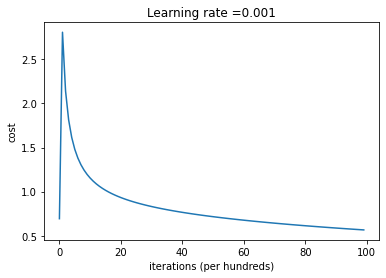

In [145]:
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()